In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath('../..'))
from models import LogisticRegression, LogisticRegressionUndersampling, LogisticRegressionOversampling, LogisticRegressionSmote
from metrics import ClassificationMetrics
from data_splitting import train_val_split
df = pd.read_csv('/home/facuvulcano/Machine-Learning/Vulcano_Facundo_TP3/Problema_1/data/raw/breast_cancer_dev.csv')

In [3]:
class0 = df[df['target'] == 0]['target']
class1 = df[df['target'] == 1]['target'], 
print(class0)
print(class1)

1      0
2      0
3      0
5      0
6      0
      ..
383    0
384    0
385    0
386    0
387    0
Name: target, Length: 302, dtype: int64
0      1
4      1
7      1
8      1
14     1
      ..
369    1
372    1
380    1
381    1
382    1
Name: target, Length: 86, dtype: int64


## **Logistic Regresion without rebalancing**

In [35]:
# reg_witout_rebalancing = LogisticRegression(threshold=0.25, max_iter=1000, learning_rate=0.01, lambda_penalty=0.01)
# X_train, X_val, y_train, y_val = train_val_split(df, 'target')
# reg_witout_rebalancing.fit(X_train, y_train)

Lambda: 0, Coefficient norm: 0.14316996431894422
Lambda: 0.0001, Coefficient norm: 0.1431697554714251
Lambda: 0.01, Coefficient norm: 0.14314908184912975
Lambda: 0.1, Coefficient norm: 0.1429613469039056
Lambda: 1, Coefficient norm: 0.14110433974871364
Lambda: 10, Coefficient norm: 0.12440180439569946
Lambda: 100, Coefficient norm: 0.0508241018057055
{0: 0.3617021276595745, 0.0001: 0.3617021276595745, 0.01: 0.3617021276595745, 0.1: 0.3617021276595745, 1: 0.3617021276595745, 10: 0.3617021276595745, 100: 0.3617021276595745}


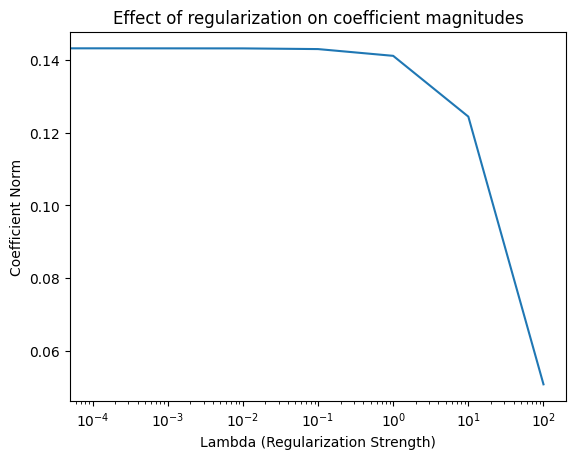

In [19]:
lambdas = [0, 0.0001, 0.01, 0.1, 1, 10, 100]
results = {}
coef_norms = []
X_train, X_val, y_train, y_val = train_val_split(df, 'target')

for lambda_ in lambdas:
    reg_witout_rebalancing = LogisticRegression(threshold=0.1, max_iter=1000, learning_rate=0.01, lambda_penalty=lambda_)
    reg_witout_rebalancing.fit(X_train, y_train)
    y_pred_val = reg_witout_rebalancing.predict(X_val)
    predicted_probabilites_val = reg_witout_rebalancing.predict_proba(X_val)
    # print(f'Predicted probabilities range: {predicted_probabilites_val.min()}, {predicted_probabilites_val.max()}')
    # print(f'Predicted classes distributions: {np.bincount(y_pred_val)}')
    metrics = ClassificationMetrics(y_val, y_pred_val, predicted_probabilites_val)
    f2_score = metrics.f_score()
    results[lambda_] = f2_score
    coef_norm = np.linalg.norm(reg_witout_rebalancing.coef_)
    coef_norms.append(coef_norm)
    # precision_values, recall_values, auc_pr_value = metrics.plot_pr_curve()
    print(f'Lambda: {lambda_}, Coefficient norm: {coef_norm}')

print(results)
plt.plot(lambdas, coef_norms)
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

In [3]:
print(X_train)

     mean concavity  concavity error  mean compactness  compactness error  \
0          0.143279         0.024497         -0.011155          -0.020849   
1          0.090541         0.019973          0.119881          -0.028008   
2          0.041530        -0.090150          0.051263           0.102735   
3          0.131825         0.054497          0.089576           0.015411   
4         -0.012507         0.105262          0.045003           0.030313   
..              ...              ...               ...                ...   
306        0.041926         0.054865          0.197420           0.003852   
307        0.182668        -0.050672          0.166601           0.017716   
308        0.193735        -0.023191          0.110340           0.014713   
309        0.078636         0.013971          0.085044           0.016875   
310        0.170572        -0.015539          0.123971          -0.032858   

     mean fractal dimension  fractal dimension error  
0                  0

In [4]:
print(len(X_val))

77


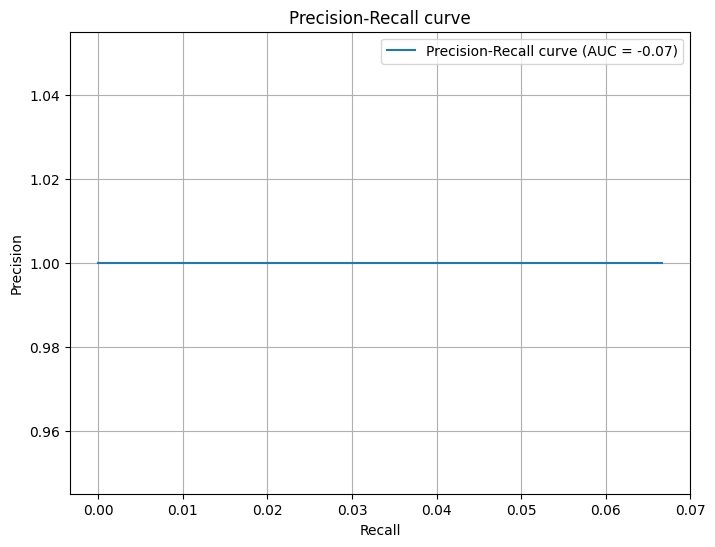

In [10]:
metrics = ClassificationMetrics(y_val, y_pred_val, predicted_probabilites_val)
precision_values, recall_values, auc_pr_value = metrics.plot_pr_curve()

para cheqquear los thresholds deberia ver curvas

In [43]:
y_pred_probs = reg_witout_rebalancing.predict_proba(np.array(X_val))
#print(y_pred_probs)

In [44]:
y_pred_train = reg_witout_rebalancing.predict(np.array(X_train))
#print(f'y_pred_train: {y_pred_train}')

In [45]:
y_pred_val = reg_witout_rebalancing.predict(np.array(X_val))
#print(f' y_pred_val: {y_pred_val}')

In [39]:
metrics = ClassificationMetrics(y_val, y_pred_val)

In [40]:
f_score = metrics.f_score()
print(f_score)

1.2195121951219512


## **Logistic Regresion with undersampling imbalance: random elimination of majority class samples until both have same proportion**

In [18]:
reg_with_undersampling = LogisticRegressionUndersampling(df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=0.01)
balanced_df = reg_with_undersampling.undersampling()
class0 = balanced_df[balanced_df['target'] == 0]['target']
class1 = balanced_df[balanced_df['target'] == 1]['target']
# print(class0)
# print(class1)
print(balanced_df)

     mean concavity  concavity error  mean compactness  compactness error  \
0          0.109220         0.028755          0.109798           0.025444   
4          0.004123         0.013759          0.008138           0.061797   
7          0.126499         0.074268          0.191562           0.094697   
8          0.223505         0.029691          0.125715           0.052720   
9          0.062064        -0.069811          0.055087          -0.027330   
..              ...              ...               ...                ...   
377       -0.040553         0.014022          0.136850           0.097129   
380        0.153378        -0.066472          0.206625           0.015916   
381        0.022832        -0.011043          0.044681           0.106355   
382        0.108200        -0.072100          0.169695           0.073082   
386        0.016147        -0.047939          0.084187           0.087969   

     mean fractal dimension  fractal dimension error  target  
0           

In [5]:
MAX_ITER = 100
global_results = {}
for iter in range(MAX_ITER):
    lambdas = [0, 0.0001, 0.01, 0.1, 1, 10, 100]
    results = {}
    coef_norms = []
    for lambda_ in lambdas:
        reg_with_undersampling = LogisticRegressionUndersampling(df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=lambda_)
        balanced_df = reg_with_undersampling.undersampling()
        X_train, X_val, y_train, y_val = train_val_split(balanced_df, 'target')
        reg_with_undersampling.fit(X_train, y_train)
        y_pred_val = reg_with_undersampling.predict(X_val)
        predicted_probabilites_val = reg_with_undersampling.predict_proba(X_val)
        # =print(f'Predicted probabilities range: {predicted_probabilites_val.min()}, {predicted_probabilites_val.max()}')
        # print(f'Predicted classes distributions: {np.bincount(y_pred_val)}')
        metrics = ClassificationMetrics(y_val, y_pred_val, predicted_probabilites_val)
        f2_score = metrics.f_score()
        results[lambda_] = f2_score
        global_results[lambda_] = (global_results.get(lambda_, 0) + f2_score)
        coef_norm = np.linalg.norm(reg_with_undersampling.coef_)
        coef_norms.append(coef_norm)
        #precision_values, recall_values, auc_pr_value = metrics.plot_pr_curve()
        #print(f'Lambda: {lambda_}, Coefficient norm: {coef_norm}')
    #print(f'f-scores: {results}')
print(global_results)

#me falta dividir por max iter para sacar el promedio


# plt.plot(lambdas, coef_norms)
# plt.xscale('log')
# plt.xlabel('Lambda (Regularization Strength)')
# plt.ylabel('Coefficient Norm')
# plt.title('Effect of regularization on coefficient magnitudes')
# plt.show()

{0: 0.00872750188118708, 0.0001: 0.007818535944257023, 0.01: 0.008807113915105906, 0.1: 0.006130715156412506, 1: 0.008312514911487302, 10: 0.00614040940183323, 100: 5.701829495518519e-07}


In [4]:
(0.6666 + 0.82725) / 2

0.7469250000000001

In [13]:
X_train, X_val, y_train, y_val = train_val_split(balanced_df, 'target')


In [14]:
print(len(X_train))
print(len(y_train))

138
138


In [5]:

print(len(X_val))
print(len(y_val))

34
34


In [15]:
reg_with_undersampling.fit(X_train, y_train)

In [16]:
y_pred_val = reg_with_undersampling.predict(X_val)
y_pred_val_probs = reg_with_undersampling.predict_proba(X_val)

In [8]:
print(y_val)

138    0
139    1
140    0
141    1
142    0
143    1
144    0
145    1
146    1
147    0
148    0
149    1
150    0
151    0
152    0
153    1
154    0
155    1
156    1
157    1
158    0
159    0
160    1
161    1
162    0
163    1
164    1
165    1
166    0
167    0
168    1
169    1
170    1
171    0
Name: target, dtype: int64


In [9]:
print(y_pred_val)

[0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0]


In [17]:
metrics = ClassificationMetrics(y_val, y_pred_val, y_pred_val_probs)
f_score = metrics.f_score()
print(f_score)

0.48888888888888893


## **Logistic Regression with oversampling by duplication: randomly duplicate samples from minority class until both have the same proportion**

In [2]:
reg_with_oversampling = LogisticRegressionOversampling(df, threshold=0.5, max_iter=1000, learning_rate=0.01, lambda_penalty=0.01)
balanced_df = reg_with_oversampling.oversampling()
class0 = balanced_df[balanced_df['target'] == 0]['target']
class1 = balanced_df[balanced_df['target'] == 1]['target']
print(class0)
print(class1)


1      0
2      0
3      0
5      0
6      0
      ..
383    0
384    0
385    0
386    0
387    0
Name: target, Length: 302, dtype: int64
0      1
4      1
7      1
8      1
14     1
      ..
86     1
196    1
117    1
366    1
8      1
Name: target, Length: 302, dtype: int64


## **Logistic Regression with SMOTE oversampling: generates synthetic samples from minority class until both have the same proportion**

In [2]:
reg_with_smote = LogisticRegressionSmote(df, threshold=0.5, max_iter=1000, learning_rate=0.01, lambda_penalty=0.01)
balanced_df = reg_with_smote.smote()
class0 = balanced_df[balanced_df['target'] == 0]['target']
class1 = balanced_df[balanced_df['target'] == 1]['target']
print(class0)
print(class1)

1      0.0
2      0.0
3      0.0
5      0.0
6      0.0
      ... 
383    0.0
384    0.0
385    0.0
386    0.0
387    0.0
Name: target, Length: 302, dtype: float64
0      1.0
4      1.0
7      1.0
8      1.0
14     1.0
      ... 
599    1.0
600    1.0
601    1.0
602    1.0
603    1.0
Name: target, Length: 302, dtype: float64


In [14]:
#Creates synthethic samples for the minority class untill the proportion is the same as the majority class
# gets a sample from the minority class and calculates k=5 (for example) nearest neighbors.
# it then calculates the interpolation of the new sample. with the formula: x_new = x_original + lambda * (x_neighbour - x_original)

#k-nearest neighbors
#we get the euclidian distance from point i to all the other samples.
#We keep the k samples with smallest euclidian distance.


# Sample DataFrame (replace this with your actual dataset)


# import random

# class KNerestNeighbors:
#     def __init__(self, k, df, class1_idxs) -> None:
#         self.k = k
#         self.df = df
#         self.class1_idxs = class1_idxs

#     def _euclidian_distance(self, row1, row2):
#         return np.sqrt(np.sum((row1 - row2) ** 2))

#     def calculate_k_nearest(self):
#         distances_dict = {}
#         for i in range(len(self.class1_idxs)):

#             distances = []
#             for j in range(len(self.class1_idxs)):
#                 if i != j:
#                     dist = self._euclidian_distance(self.df.iloc[self.class1_idxs[i]], self.df.iloc[self.class1_idxs[j]])
#                     distances.append((dist, self.class1_idxs[j]))
                    
#             distances.sort()
#             distances_dict[self.class1_idxs[i]] = distances[:self.k]       
#         return distances_dict

# # Inicialization and neighbour calculation
# knn = KNerestNeighbors(k=5, df=df, class1_idxs=class1_idxs)
# k_nearest_distances = knn.calculate_k_nearest()
# # imbalance between clases
# diff = len(class0) - len(class1)
# new_rows = []
# # Counter to ciclic iterate throw the class1_idxs
# index_counter = 0
# #Create new rows until dataset is balanced
# while len(new_rows) < diff:
#     #get index ciclcly
#     key = class1_idxs[index_counter % len(class1_idxs)]
#     #get x_original based on the key
#     x_original = df.iloc[key]
#     #get a random neighbour from the k nearer
#     value = k_nearest_distances[key]
#     random_neighbour_index = random.choice(value)[1]
#     x_neighbour =  df.iloc[random_neighbour_index]


#     lamb = np.random.uniform(0, 1)

#     new_row = x_original + lamb * (x_neighbour - x_original)
#     new_rows.append(new_row)

#     index_counter += 1


{0: [(0.055444794183309824, 169), (0.05626013103546007, 270), (0.06320975033768471, 54), (0.07426021259617163, 262), (0.08647294226990418, 237)], 4: [(0.07064682707159745, 381), (0.12046070435105206, 26), (0.1226885911167266, 146), (0.12308715134800191, 220), (0.14169778334911046, 318)], 7: [(0.06283111739550216, 176), (0.07145212301086601, 237), (0.09171945753666981, 158), (0.1085646416409678, 369), (0.11286888157143807, 349)], 8: [(0.061188800997155915, 84), (0.06404837053463333, 186), (0.06408336254504371, 14), (0.06498715525902413, 275), (0.066496147556151, 211)], 14: [(0.02450923974552526, 211), (0.06408336254504371, 8), (0.07415662606239984, 84), (0.07724741843500496, 289), (0.08535378527051746, 335)], 17: [(0.08346220680867848, 100), (0.11615705025291433, 171), (0.11639899276546081, 353), (0.11659462966710157, 335), (0.117658619239518, 146)], 18: [(0.07519653054157928, 173), (0.09745258820312072, 220), (0.12047954010536056, 169), (0.12068068092011901, 0), (0.1257593973631509, 26